# Real-time dynamics

In this tutorial, we will discuss how to use Quantax to simulate real-time dynamics $\ket{\dot \psi} = -i H \ket{\psi}$ in a $4 \times 4$ transverse-field Ising model.

We will start from a product state $\ket{\psi_0} = (\ket{\uparrow} + \ket{\downarrow})^{\otimes N}$, and simulate quench given Ising Hamiltonian.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx
import quantax as qtx
from quantax.symmetry import TransND, C4v, SpinInverse
from IPython.display import clear_output
%config InlineBackend.figure_format = 'svg'

qtx.set_default_dtype(jnp.complex128)

lattice = qtx.sites.Square(4)
N = lattice.Nsites

H = qtx.operator.Ising(h=6)

## Exact evolution

In small systems, one can utilize QuSpin to obtain exact evolution trajectory.

We start with the initial product state $\ket{\psi_0}$. To reduce the cost of evolution, it's usually important to restrict the state into a specific symmetry sector.

In [2]:
psi0 = np.ones((1 << N,), dtype=jnp.complex128)
psi0 = qtx.state.DenseState(psi0)

symm = TransND() @ C4v() @ SpinInverse()
psi0 = psi0.todense(symm).normalize()

/home/aochen/quantax_env/lib/python3.12/site-packages/quantax/symmetry/symmetry.py:288: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(


Then we perform the evolution using a QuSpin operator. It will take some time.

In [3]:
op = H.get_quspin_op(symm)
t0 = 0.0
times = np.linspace(0, 1, 1001)

psit = op.evolve(psi0.psi, t0, times)

Now we can measure the evolution of $\braket{\sigma_i^x}$.

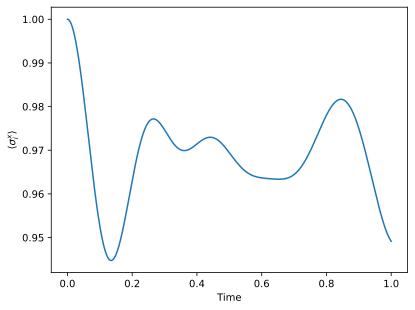

In [4]:
from quantax.operator import sigma_x

opx = sum(sigma_x(i) for i in range(N)) / N
psit = [qtx.state.DenseState(psi, symm=symm) for psi in psit.T]
sx_exact = [psi @ opx @ psi for psi in psit]
sx_exact = np.asarray(sx_exact).real
plt.plot(times, sx_exact)
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma_i^x \rangle$')
plt.show()

## NQS preparation

The first step of neural-network unitary dynamics is also preparing an initial state. It's hard to set the wavefunction amplitudes directly in an NQS. Here, we prepare the initial state by searching for the ground state of $H_0 = -\sum_i \sigma_i^x$.

E0106 09:48:23.025522 1531416 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0106 09:48:23.254585 1531416 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0106 09:48:23.577108 1531416 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0106 09:48:23.912475 1531416 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0106 09:48:24.170000 1531416 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0106 09:48:24.491987 1531416 cuda_timer.cc:8

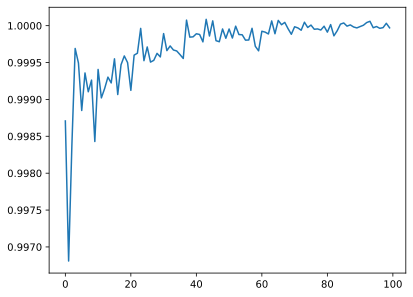

In [5]:
model = qtx.model.ResConv(
    nblocks=2, channels=8, kernel_size=3, dtype=jnp.float32, out_dtype=jnp.complex128
)
# Translation symmetry is encoded in ResConv, so it's not needed here
symm1 = C4v() @ SpinInverse()

state = qtx.state.Variational(model, symm=symm1)
sampler0 = qtx.sampler.LocalFlip(state, 1024)
optimizer = qtx.optimizer.SR(state, -opx)

sx = qtx.utils.DataTracer()

for i in range(100):
    samples = sampler0.sweep()
    step = optimizer.get_step(samples)
    state.update(step * 0.1)
    sx.append(-optimizer.energy)

sx.plot()
plt.show()

state.save("/tmp/dynamics.eqx")

In practice, the choice of the initial state $\ket{\psi_0}$ depends on the physical background. For instance, $\ket{\psi_0}$ can be an excitation of a ground state if one needs to study low-energy spectrum.

## Non-stochastic TDVP

The method simulating unitary dynamics with variational wavefunctions is called time-dependent variational principle (TDVP). We start with non-stochastic TDVP supported by {py:class}`~quantax.optimizer.ER`. As explained in [Build your network](https://chenao-phys.github.io/quantax/tutorials/2-build_net.html), it's restricted to small systems and helps us to check the expressivity of neural networks by excluding stochastic errors. 

Assume the evolution trajectory is determined by

$$
\dot \theta = f(\theta),
$$

where $\theta$ is variational parameters. In ground-state search, one update $\theta$ up to the first order, i.e.

$$
\theta(t_0 + \Delta t) = \theta(t_0) + f(\theta(t_0)).
$$

In unitary dynamics, one has to employ higher order updates to ensure accuracy in every step. We will utilize the Heun's method given by

$$
\begin{aligned}
    k_1 &= f(\theta(t_0)), \\
    k_2 &= f(\theta(t_0) + k_1 \Delta t), \\
    \theta(t_0 + \Delta t) &= \theta(t_0) + \frac{k_1 + k_2}{2} \Delta t.
\end{aligned}
$$

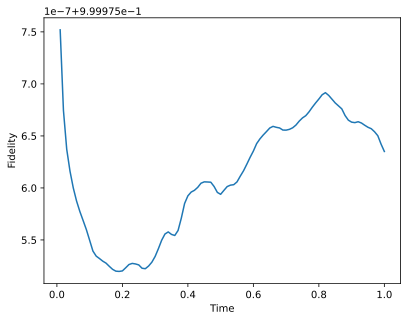

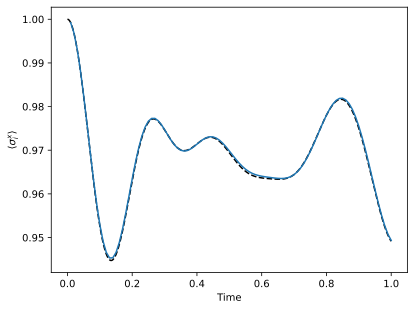

In [8]:
state = qtx.state.Variational(model, "/tmp/dynamics.eqx", symm=symm1)
optimizer = qtx.optimizer.ER(state, H, imag_time=False, symm=symm)

dt = 0.001

fidelity = qtx.utils.DataTracer()
sx_etdvp = qtx.utils.DataTracer()

for i in range(1, 1001):
    step1 = optimizer.get_step()
    state.update(step1 * dt)
    step2 = optimizer.get_step()
    state.update((step2 - step1) * dt / 2)

    if i % 10 == 0:
        clear_output(wait=True)
        dense = state.todense(symm).normalize()
        fidelity.append(abs(dense @ psit[i]) ** 2, time=i * dt)
        sx_etdvp.append((dense @ opx @ dense).real, time=i * dt)

        fidelity.plot()
        plt.xlabel('Time')
        plt.ylabel('Fidelity')
        plt.show()

        plt.plot(times, sx_exact, 'k--')
        sx_etdvp.plot()
        plt.xlabel('Time')
        plt.ylabel(r'$\langle \sigma_i^x \rangle$')
        plt.show()

The fidelity is high during the evolution, and $\braket{\sigma_i^x}$ matches well with the exact values. These results show that `ResConv` has enough expressivity for the dynamics.

## Stochastic TDVP

Next, we will introduce stochastic evolution supported by `TimeEvol`, which is equivalent to real-time {py:class}`~quantax.optimizer.ER`. We need to specify more samples and sampling steps to reduce stochastic errors.

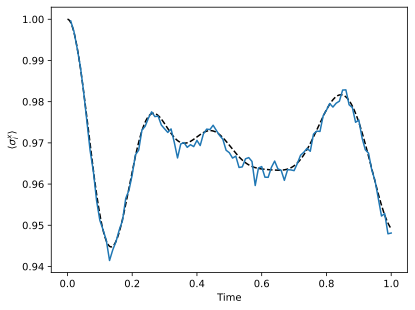

In [6]:
state = qtx.state.Variational(model, "/tmp/dynamics.eqx", symm=symm1)
sampler = qtx.sampler.LocalFlip(
    state, nsamples=8192, thermal_steps=50 * N, sweep_steps=5 * N
)
optimizer = qtx.optimizer.TimeEvol(state, H)

dt = 0.001

sx_etdvp = qtx.utils.DataTracer()

for i in range(1, 1001):
    samples = sampler.sweep()
    step1 = optimizer.get_step(samples)
    state.update(step1 * dt)

    samples = sampler.sweep()
    step2 = optimizer.get_step(samples)
    state.update((step2 - step1) * dt / 2)

    if i % 10 == 0:
        clear_output(wait=True)
        sx_etdvp.append(opx.expectation(state, samples), time=i * dt)

        plt.plot(times, sx_exact, "k--")
        sx_etdvp.plot()
        plt.xlabel("Time")
        plt.ylabel(r"$\langle \sigma_i^x \rangle$")
        plt.show()

    if i % 50 == 0:
        # Reset all Markov chains to improve sampling quality
        sampler.reset()